## Negative Binomial VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Negative Binomial base distribution with Log Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = 0.05 * \mathbf{1_{n} 1_{n}^\top}
$$

In this example simulate three fixed effects under GLMM with $\beta \sim$ randn(Uniform(-0.2, 0.2), p) where p = 3 fixed effects.

We run each scenario 5 times and compare the fit of ours with that of GLMM's random intercept model from MixedModels.jl. 

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p  = 3    # number of fixed effects, including intercept
m  = 1    # number of variance components
# true parameter values
Random.seed!(1234)
βtrue = rand(Uniform(-0.2, 0.2), p)
rtrue = 10.0
θtrue = [0.05]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; rtrue; θtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000; 100000]
ns = [2; 5; 10]
nsims = 5

5

In [5]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_nb_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_nb_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_nb_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[5]:1


60-element Vector{Float64}:
   0.06391984
   0.311538895
   0.0831417
   0.231379062
   0.105632918
   0.182696042
   0.20399378
   0.092420215
   0.118090209
   0.089007143
   0.217327994
   0.230940765
   0.233469511
   ⋮
  69.135167438
  78.522058692
  76.330089214
  90.208001287
  67.99841716
  72.299026308
  77.996566551
 130.099887313
 115.000477044
 117.468231345
 121.151318991
 123.621297709

In [6]:
fittimes_GLMM = vec(readdlm("fittimes_GLMM_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))

60-element Vector{Float64}:
    0.268586854
    0.040495002
    0.078069682
    0.023185246
    0.026422551
    0.147727289
    0.092301654
    0.103794381
    0.074717474
    0.097020635
    0.268123279
    0.505422773
    0.327284457
    ⋮
  187.495863028
  116.945108182
  487.430452926
  316.908569884
  403.864143304
  392.391065161
  632.550692326
  984.092001087
 1015.581219262
  846.542703276
  964.974925565
  868.433022677

In [9]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1[!, 1:4]

┌ Info: making results table Quasi-Copula
└ @ Main In[9]:2


,samplesize,obssize,fittime,se
,String,String,Float64,Float64
1,100,2,0.159122,0.0480362
2,100,5,0.137241,0.0236899
3,100,10,0.23732,0.0100071
4,1000,2,0.665059,0.0356822
5,1000,5,0.68667,0.023111
6,1000,10,1.02385,0.0226212
7,10000,2,6.60604,0.215899
8,10000,5,7.29045,0.0806815
9,10000,10,11.4403,0.137068


In [10]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2[!, 1:4]

┌ Info: making results table GLMM
└ @ Main In[10]:2


,samplesize,obssize,fittime,se
,String,String,Float64,Float64
1,100,2,0.0873519,0.0463452
2,100,5,0.103112,0.0121474
3,100,10,0.354081,0.0504375
4,1000,2,0.456188,0.0550885
5,1000,5,1.44295,0.146106
6,1000,10,4.13671,1.29943
7,10000,2,5.40915,0.616827
8,10000,5,39.4608,2.9736
9,10000,10,93.4428,3.258


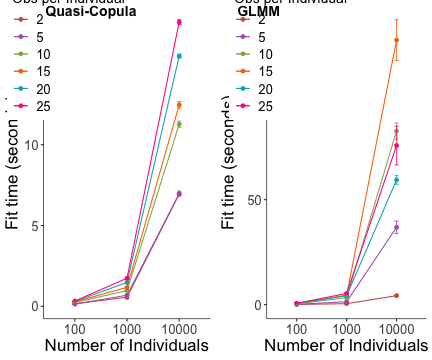

RObject{VecSxp}


In [28]:
########### plot the runtimes
using RCall
@rput timedf1
@rput timedf2
R"""
library(ggplot2)
library(cowplot)
timedf1$obssize = factor(timedf1$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf1$samplesize = factor(timedf1$samplesize, levels = c('100', '1000', '10000'))

fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

timedf2$obssize = factor(timedf2$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf2$samplesize = factor(timedf2$samplesize, levels = c('100', '1000', '10000'))

fittime_2 = ggplot(timedf2, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

fittime_nsamples = plot_grid(fittime_1, fittime_2, labels = c("Quasi-Copula", "GLMM"))
"""

In [29]:
R"""
ggsave('sim_glmm_fittime_nsamples_nb_vs_glmm.png', fittime_nsamples, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "sim_glmm_fittime_nsamples_nb_vs_glmm.png"


In [30]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βθrcoverage = readdlm("beta_r_sigma_coverage_multivariate_NB_vcm$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βθrcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["r"]; ["θ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p];  ["r"];  ["θ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,r
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.0, 0.0)","(0.4, 0.244949)","(0.4, 0.244949)","(0.0, 0.0)"
2,N: 100 ni: 5,"(0.0, 0.0)","(0.4, 0.244949)","(0.4, 0.244949)","(0.0, 0.0)"
3,N: 100 ni: 10,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
4,N: 100 ni: 15,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
5,N: 100 ni: 20,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
6,N: 100 ni: 25,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
7,N: 1000 ni: 2,"(0.0, 0.0)","(0.2, 0.2)","(0.2, 0.2)","(0.0, 0.0)"
8,N: 1000 ni: 5,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
9,N: 1000 ni: 10,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"


In [31]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult = vec(readdlm("mse_beta_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
rMseresult =  vec(readdlm("mse_r_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))

βMseresult_GLMM = vec(readdlm("mse_beta_GLMM_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
θMseresult_GLMM = vec(readdlm("mse_Sigma_GLMM_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
rMseresult_GLMM =  vec(readdlm("mse_r_GLMMmultivariate_NB_vcm$(nsims)reps_sim.csv", ','))


p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresult, thetamse = θMseresult, rmse = rMseresult,
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresult_GLMM, thetamse = θMseresult_GLMM, rmse = rMseresult_GLMM,
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "thetamse"
        "rmse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "thetamse"
        "rmse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :thetamse];msedf1[!, :rmse]; msedf2[!, :betamse]; msedf2[!, :thetamse]; msedf2[!, :rmse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 3)]...) ; collect([repeat(msedf2[!, :obssize], 3)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 3)]...) ; collect([repeat(msedf2[!, :samplesize], 3)]...)]

parameters = [collect([repeat(string.([:beta, :theta, :r]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :theta, :r]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["NegBinomial Quasi-Copula"], 3 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["NegBinomial GLMM"],  3 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.00333324,2,100,beta,NegBinomial Quasi-Copula
2,0.00408972,2,100,beta,NegBinomial Quasi-Copula
3,0.00457845,2,100,beta,NegBinomial Quasi-Copula
4,0.00678895,2,100,beta,NegBinomial Quasi-Copula
5,0.00943784,2,100,beta,NegBinomial Quasi-Copula
6,0.00867752,5,100,beta,NegBinomial Quasi-Copula
7,0.00108991,5,100,beta,NegBinomial Quasi-Copula
8,0.00130847,5,100,beta,NegBinomial Quasi-Copula
9,0.00182908,5,100,beta,NegBinomial Quasi-Copula


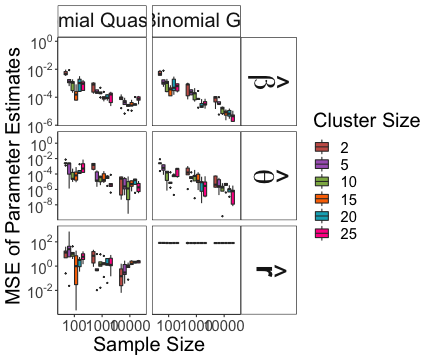

RObject{VecSxp}


In [32]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-4]
msedfR[parameters == "beta",y_max := 10^0]
msedfR[parameters == "theta",y_min := 10^-4]
msedfR[parameters == "theta",y_max := 10^1]
msedfR[parameters == "r", y_min := 10^-3]
msedfR[parameters == "r", y_max := 10^3]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta', 'r'), labels = c(beta = expression(hat(bold(beta))), theta = expression(hat(bold(theta))[]), r = expression(hat(bold(r))[])))
msedfR$robust <- factor(msedfR$robust, levels = c('NegBinomial Quasi-Copula', 'NegBinomial GLMM'),
    labels = c(expression(paste("NegBinomial Quasi-Copula")), expression(paste("NegBinomial GLMM"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=15),
        axis.text.y = element_text(angle=0, size=15), axis.title.x = element_text(size = 20), 
        axis.title.y = element_text(size = 20), legend.title = element_text(size = 20),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=15), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=30, face="bold"),
        strip.text.x = element_text(size=20)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 
"""

In [33]:
R"""
ggsave('sim_glmm_updated_msefacetplot_nb2.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "sim_glmm_updated_msefacetplot_nb2.png"
